To assess the impact of sequencing depth on caQTL identification, the WASP-filtered ‘bulk’ alignments were subsampled to 25% of depth using ‘samtools view -s 0.25’ and caQTL analysis was repeated. 
### Subsample bam files

In [1]:
library(parallel)

In [2]:
ids = c(2:5, 8:10,12:14) 

In [3]:
sampdir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp_peaks/bulk/'

In [4]:
outdir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/subsample_bulk/'

In [5]:
subset_bam = function(s) {
    
sample      = paste0("pbmc",s)
bam_in      = paste0(sampdir, "/PBMC", s, '/rmdup/PBMC', s, '.keep.merged.rmdup.bam' )
bam_out     = paste0(outdir, sample,'.wasped.sub025.bam' )
cmd = paste("samtools view -s 0.25 -b", bam_in ,'>', bam_out)
system(cmd)
    }

In [7]:
mclapply(ids, subset_bam, mc.cores=24)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

In [39]:
sort_and_index = function(s){
sample      = paste0("pbmc",s)
outdir         = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/subsample_bulk/'
bam_out        = paste0(outdir, sample,'.wasped.sub025.bam' )
sorted_bam     = paste0(outdir, sample,'.wasped.sub025.sorted.bam' )    
system(paste('samtools', 'sort', '-m', '2G', '-@', '3', '-o', sorted_bam, bam_out)) 
system(paste("samtools index", sorted_bam))
}

In [ ]:
mclapply(ids, sort_and_index, mc.cores=30)

### Prepare count matrix

In [5]:
sampdir  = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/subsample_bulk/'
outdir   = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/'
bedir    = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/peaks/'

In [9]:
saf = paste0(bedir, 'pbmc.sorted.merged.saf')

In [10]:
### pseudobulk matrix
res = "bulk"
c   =  'bulk025'
outfolder     = paste(outdir, res, c, sep="/")
system(paste('mkdir -p' , outfolder))
count_matrix  = paste0(outfolder,"/" ,c, '.count_matrix')    
bam           = paste0("/nfs/lab/projects/pbmc_snATAC/analysis_v2/subsample_bulk/pbmc", ids, '.wasped.sub025.bam' )
gi  <-  paste("featureCounts -p -T 10 -F SAF --donotsort -a" , saf, "-o",  count_matrix , 
                paste(bam,collapse=" "))



In [11]:
system(gi)

In [6]:
library("rasqualTools")
source("/nfs/lab/projects/pbmc_snATAC/scripts/rasqual_tools_functions.R")

In [14]:

outfolder     = paste(outdir, res, c, sep="/")
cm = read.table(paste0(outfolder, "/" ,c, '.count_matrix') , header=T)
colnames(cm)[7:ncol(cm)] = paste0("PBMC", ids)

### filter for peaks having a minumum of 5 reads on avg per sample
cm = cm[rowMeans(cm[,7:ncol(cm)])>= 5, ]

fmat           = cm[,7:ncol(cm)]
rownames(fmat) = cm[,1]
filtbed        = paste0(outfolder, "/", c, ".filtered.bed")
write.table(fmat, paste0(outfolder, "/", c, ".filtered.count_matrix"), sep="\t", quote=F)
write.table(cm[,2:4],filtbed, sep="\t", quote=F, col.names=F, row.names=F)
cc     = cm[,2:4]
cc[,1] = substring(cc[,1],4)
write.table(cc, paste0(outfolder, "/", c, ".filtered.nochr.bed"), sep="\t", quote=F, col.names=F, row.names=F)

system(paste0("bedtools slop -i ",  filtbed,  " -b 10000 -g /nfs/lab/publicdata/human.hg19.genome.bedtools > ",
         filtbed, '.10kb'))

system(paste0("bedtools merge -i ", filtbed, '.10kb > ', filtbed, '.10kb.merged'))

fb     = read.table(paste0( filtbed, '.10kb.merged'))
fb[,1] = substring(fb[,1],4)
write.table(fb, paste0( filtbed, '.10kb.merged.nochr'), sep="\t", quote=F, col.names=F, row.names=F)

#### RAsqualTools

saveRasqualMatrices(list(counts = fmat), outfolder, file_suffix = c)

size_factors = rasqualCalculateSampleOffsets(fmat, gc_correct = FALSE)
saveRasqualMatrices(list(size_factors = size_factors),  outfolder, file_suffix = c)

y = paste0(outfolder, "/counts.",c, ".txt" )
k = paste0(outfolder, "/size_factors.",c, ".txt" )
x = paste0(outfolder, "/covariates.",c, ".txt" )

make_covariates (ytxt=y, ktxt=k, outfile=x)

txt2bin  (ytxt=y, ktxt=k, xtxt=x)


[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur//bulk/bulk025/counts.bulk025.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur//bulk/bulk025/size_factors.bulk025.txt"


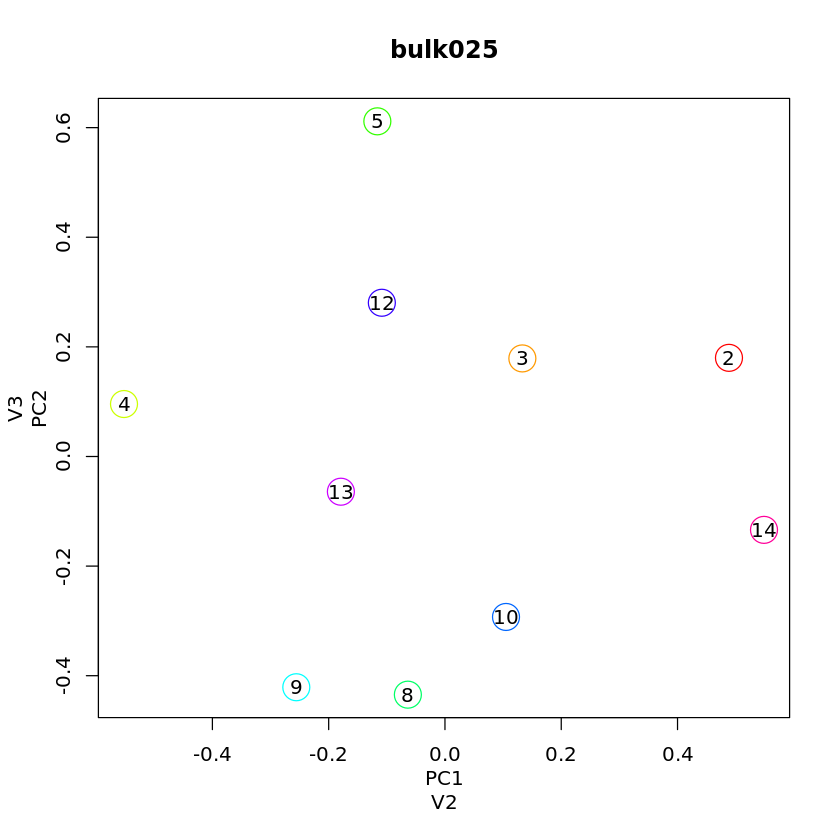

In [15]:

outfolder     = paste(outdir, res, c, sep="/")
pca = read.table(paste0(outfolder, "/covariates.",c, ".txt" ))
   
plot(pca[,2:3], cex = 3, main = c, col = rainbow(length(ids))) ## col1 is size factor
mtext(side = 1:2, text=c("PC1","PC2"), line=2)
text(pca[,2:3], labels = ids)
#plot(pca[,3:4], cex = 3, main = c) ## col1 is size factor
#text(pca[,3:4], labels = ids)
#mtext(side = 1:2, text=c("PC2","PC3"), line=2)    


In [16]:
codir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual/covariates/'

outfolder     = paste(outdir, res, c, sep="/")
y = paste0(outfolder, "/counts.",c, ".txt" )
k = paste0(outfolder, "/size_factors.",c, ".txt" )
x = paste0(outfolder, "/covariates2.",c, ".txt" )
    
make_covariates (ytxt=y, ktxt=k, outfile=x) ###recalculate original ones 
#newcov = cbind(read.table(x), read.table(paste0(codir, "4_gt_pcs")))
newcov = cbind(read.table(x),
               #read.table(paste0(codir, "age"))[-c(1,6,13),],
               #read.table(paste0(codir, "sex"))[-c(1,6,13),]*0.1, 
               read.table(paste0(codir, "4_gt_pcs"))[-c(1,6,13),])

write.table( newcov, x, col=F,row=F,sep="\t",quote=F)
txt2bin  (ytxt=y, ktxt=k, xtxt=x)


### Make vcf file

In [7]:
vcf_dir = '/nfs/lab/projects/pbmc_snATAC/pipeline/snp_array/final_vcfs/'

In [8]:
homedir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/'

In [46]:
filter_vcf = function(cell) {
        
    for (n in 1:22) {

    vcf    = paste0(vcf_dir, "/chr",n ,'.PBMC.topmed.hg19.final.vcf.gz')
    outdir = paste(homedir, reso, cell, "vcfs_peaksonly", sep="/")    
    system(paste("mkdir -p ",outdir  ) )   
    outvcf = paste0(outdir, "/chr",n ,'.filt.vcf.gz')
    bed    = paste0(homedir, reso, "/",cell, "/" , cell, '.filtered.bed')
        
    system(paste('bcftools view', vcf ,
    '-R' , bed, 
    '-s PBMC2,PBMC3,PBMC4,PBMC5,PBMC8,PBMC9,PBMC10,PBMC12,PBMC13,PBMC14',
    '--types snps' ,         
    "-i \'INFO/R2[0]>0.7\' | bcftools view -i \'COUNT(GT=\"het\")>1\' -Oz -o", outvcf))
        
        
}
    }

In [47]:
reso      = "bulk"
cell      = 'bulk025'

In [48]:
mclapply(cell, function(x) filter_vcf(x) , mc.cores = 20)

[[1]]
NULL

In [49]:
new_vcf_dir = paste0(homedir, reso,"/" ,cell, "/vcfs_peaksonly" )    
sampdir     = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/subsample_bulk"

sorted_bam= paste0(sampdir, "/pbmc", ids, '.wasped.sub025.sorted.bam' )

writeLines(sorted_bam, paste(new_vcf_dir, 'bam.list.txt', sep="/"))

In [50]:
rasqual_ase = function (cell, reso, chr){
setwd(paste0(homedir, reso,"/" ,cell, "/vcfs_peaksonly" )  )
outfile = paste0( "chr",chr, '.ase.filtered.vcf.gz')   
system(paste0('tabix chr', chr, '.filt.vcf.gz -f' ))     
system(paste0('bash /nfs/lab/paola/rasqual/src/ASVCF/createASVCF.sh paired_end bam.list.txt chr',chr,
              '.filt.vcf.gz chr', chr, '.ase.filtered.vcf.gz atac'))
system(paste('tabix', outfile, '-f'))
    }

In [51]:
mclapply(1:22, function (x) rasqual_ase(cell='bulk025', reso=reso,chr=x ),mc.cores = 22)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

[[16]]
[1] 0

[[17]]
[1] 0

[[18]]
[1] 0

[[19]]
[1] 0

[[20]]
[1] 0

[[21]]
[1] 0

[[22]]
[1] 0

In [52]:
vcflist = paste(paste0( "chr",1:22, '.ase.filtered.vcf.gz') , collapse = " ")

In [53]:

setwd(paste(homedir, reso, cell, "vcfs_peaksonly", sep="/"))
system(paste("bcftools concat", vcflist,  "-Oz -o full.ase.filtered.vcf.gz"))
#system("awk \'{if($0 !~ /^#/) print \"chr\"$0; else print $0}\' full.vcf > full.chr.vcf")
#system('bgzip full.chr.vcf -f')
system('tabix full.ase.filtered.vcf.gz -f')
    

In [54]:
homedir


[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/"

### Repeat the analysis on the 10 kb window (not only peaks)

In [8]:
filter_vcf = function(cell) {
        
    for (n in 1:22) {

    vcf    = paste0(vcf_dir, "/chr",n ,'.PBMC.topmed.hg19.final.vcf.gz')
    outdir = paste(homedir, reso, cell, "vcfs_peaks10kb", sep="/")    
    system(paste("mkdir -p ",outdir  ) )   
    outvcf = paste0(outdir, "/chr",n ,'.filt.vcf.gz')
    bed    = paste0(homedir, reso, "/",cell, "/" , cell, '.filtered.bed.10kb.merged')
        
    system(paste('bcftools view', vcf ,
    '-R' , bed, 
    '-s PBMC2,PBMC3,PBMC4,PBMC5,PBMC8,PBMC9,PBMC10,PBMC12,PBMC13,PBMC14',
    '--types snps' ,         
    "-i \'INFO/R2[0]>0.7\' | bcftools view -i \'COUNT(GT=\"het\")>1\' -Oz -o", outvcf))
        
        
}
    }

In [9]:
reso      = "bulk"
cell      = 'bulk025'

In [10]:
mclapply(cell, function(x) filter_vcf(x) , mc.cores = 20)

[[1]]
NULL

In [11]:
new_vcf_dir = paste0(homedir, reso,"/" ,cell, "/vcfs_peaks10kb" )    
sampdir     = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/subsample_bulk"

sorted_bam= paste0(sampdir, "/pbmc", ids, '.wasped.sub025.sorted.bam' )

writeLines(sorted_bam, paste(new_vcf_dir, 'bam.list.txt', sep="/"))

In [12]:
rasqual_ase = function (cell, reso, chr){
setwd(paste0(homedir, reso,"/" ,cell, "/vcfs_peaks10kb" )  )
outfile = paste0( "chr",chr, '.ase.filtered.vcf.gz')   
system(paste0('tabix chr', chr, '.filt.vcf.gz -f' ))     
system(paste0('bash /nfs/lab/paola/rasqual/src/ASVCF/createASVCF.sh paired_end bam.list.txt chr',chr,
              '.filt.vcf.gz chr', chr, '.ase.filtered.vcf.gz atac'))
system(paste('tabix', outfile, '-f'))
    }

In [13]:
mclapply(1:22, function (x) rasqual_ase(cell='bulk025', reso=reso,chr=x ),mc.cores = 22)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

[[16]]
[1] 0

[[17]]
[1] 0

[[18]]
[1] 0

[[19]]
[1] 0

[[20]]
[1] 0

[[21]]
[1] 0

[[22]]
[1] 0

In [15]:
vcflist = paste(paste0( "chr",1:22, '.ase.filtered.vcf.gz') , collapse = " ")

setwd(paste(homedir, reso, cell, "vcfs_peaks10kb", sep="/"))
system(paste("bcftools concat", vcflist,  "-Oz -o full.ase.filtered.vcf.gz"))
#system("awk \'{if($0 !~ /^#/) print \"chr\"$0; else print $0}\' full.vcf > full.chr.vcf")
#system('bgzip full.chr.vcf -f')
system('tabix full.ase.filtered.vcf.gz -f')
 

### Repeat the analysis on the 50 kb window (not only peaks)

In [20]:
outfolder     = paste(homedir, reso, cell, sep="/")  

In [24]:
filtbed        = paste0(outfolder, "/", cell, ".filtered.bed")
system(paste0("bedtools slop -i ",  filtbed,  " -b 50000 -g /nfs/lab/publicdata/human.hg19.genome.bedtools > ",
         filtbed, '.50kb'))
system(paste0("bedtools merge -i ", filtbed, '.50kb > ', filtbed, '.50kb.merged'))


In [25]:
filter_vcf = function(cell) {
        
    for (n in 1:22) {

    vcf    = paste0(vcf_dir, "/chr",n ,'.PBMC.topmed.hg19.final.vcf.gz')
    outdir = paste(homedir, reso, cell, "vcfs_peaks50kb", sep="/")    
    system(paste("mkdir -p ",outdir  ) )   
    outvcf = paste0(outdir, "/chr",n ,'.filt.vcf.gz')
    bed    = paste0(homedir, reso, "/",cell, "/" , cell, '.filtered.bed.50kb.merged')
        
    system(paste('bcftools view', vcf ,
    '-R' , bed, 
    '-s PBMC2,PBMC3,PBMC4,PBMC5,PBMC8,PBMC9,PBMC10,PBMC12,PBMC13,PBMC14',
    '--types snps' ,         
    "-i \'INFO/R2[0]>0.7\' | bcftools view -i \'COUNT(GT=\"het\")>1\' -Oz -o", outvcf))
        
        
}
    }

In [26]:
mclapply(cell, function(x) filter_vcf(x) , mc.cores = 20)

[[1]]
NULL

In [27]:
new_vcf_dir = paste0(homedir, reso,"/" ,cell, "/vcfs_peaks50kb" )    
sampdir     = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/subsample_bulk"

sorted_bam= paste0(sampdir, "/pbmc", ids, '.wasped.sub025.sorted.bam' )

writeLines(sorted_bam, paste(new_vcf_dir, 'bam.list.txt', sep="/"))

In [28]:
rasqual_ase = function (cell, reso, chr){
setwd(paste0(homedir, reso,"/" ,cell, "/vcfs_peaks50kb" )  )
outfile = paste0( "chr",chr, '.ase.filtered.vcf.gz')   
system(paste0('tabix chr', chr, '.filt.vcf.gz -f' ))     
system(paste0('bash /nfs/lab/paola/rasqual/src/ASVCF/createASVCF.sh paired_end bam.list.txt chr',chr,
              '.filt.vcf.gz chr', chr, '.ase.filtered.vcf.gz atac'))
system(paste('tabix', outfile, '-f'))
    }

In [29]:
mclapply(1:22, function (x) rasqual_ase(cell='bulk025', reso=reso,chr=x ),mc.cores = 22)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

[[16]]
[1] 0

[[17]]
[1] 0

[[18]]
[1] 0

[[19]]
[1] 0

[[20]]
[1] 0

[[21]]
[1] 0

[[22]]
[1] 0

In [30]:
vcflist = paste(paste0( "chr",1:22, '.ase.filtered.vcf.gz') , collapse = " ")

setwd(paste(homedir, reso, cell, "vcfs_peaks50kb", sep="/"))
system(paste("bcftools concat", vcflist,  "-Oz -o full.ase.filtered.vcf.gz"))
#system("awk \'{if($0 !~ /^#/) print \"chr\"$0; else print $0}\' full.vcf > full.chr.vcf")
#system('bgzip full.chr.vcf -f')
system('tabix full.ase.filtered.vcf.gz -f')


### Count how many SNPs are filered that are less than 2 hets

In [10]:
reso      = "bulk"
cell      = 'bulk'

In [13]:
homedir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/test_countvar/'
dir.create(homedir)

In [19]:
    for (n in 1:22) {

    vcf    = paste0(vcf_dir, "/chr",n ,'.PBMC.topmed.hg19.final.vcf.gz')
    outvcf  = paste0(homedir, "/chr",n ,'.filt1.vcf.gz')
    outsnps = paste0(homedir, "/chr",n ,'.filt1.snps')
    bed      = paste0('/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/', reso, "/",cell, "/" , cell, '.filtered.bed')
        
    system(paste('bcftools view', vcf ,
    '-R' , bed, 
    '-s PBMC2,PBMC3,PBMC4,PBMC5,PBMC8,PBMC9,PBMC10,PBMC12,PBMC13,PBMC14',
    '--types snps' ,         
    "-i \'INFO/R2[0]>0.7\' -Oz -o", outvcf))
    
    system(paste("bcftools query -f '%CHROM\\t%POS\\t%ID\\n'", outvcf, ">", outsnps))   
    
    outsnps2 = paste0(homedir, "/chr",n ,'.filt2.snps')
        
   system(paste('bcftools view', outvcf,
                "-i \'COUNT(GT=\"het\")>0\' | bcftools query -f '%CHROM\\t%POS\\t%ID\\n' >", outsnps2))
    
    outsnps3 = paste0(homedir, "/chr",n ,'.filt3.snps')
        
   system(paste('bcftools view', outvcf,
                "-i \'COUNT(GT=\"het\")>1\' | bcftools query -f '%CHROM\\t%POS\\t%ID\\n' >", outsnps3))
       
        
        }

        
           

In [16]:
 377070 # SNPS in peaks R20.7

 308460 # SNPs in peaks R20.7 with at least 1 het

 215925 # SNPs in peaks R20.7 with at least 2 het

In [18]:
215925/377070

[1] 0.572639

In [21]:
215925/308460

[1] 0.7000097